In [1]:
# Challenge: https://www.kaggle.com/c/yelp-restaurant-photo-classification
import os
import numpy as np
import pandas as pd
import IPython
from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import misc
import pydot

# Keras (https://github.com/fchollet/keras/)
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import callbacks


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

Using Theano backend.


## Yelp data provider class

In [2]:
# default image preprocess
def dflt_img_preprocess_fn(img, resize_dim=(480, 480, 3)):
    return misc.imresize(img, resize_dim, interp="nearest")
                
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

# prepare image for vggnet
def prepare_image_for_vggnet(img, resize_dim=(224, 224, 3), sub_vgg_mean=False, depth_first=True, dtype=np.float32):

    if resize_dim == -1:
        img = img.astype(dtype)
    else:
        img = misc.imresize(img, resize_dim, interp="nearest").astype(dtype)

    if sub_vgg_mean:
        img[:,:,0] -= dtype(103.939)
        img[:,:,1] -= dtype(116.779)
        img[:,:,2] -= dtype(123.68)

    if depth_first:
        img = img.transpose((2,0,1))

    return img

"""
train_photo_biz_tbl: training dataframe, photo - biz id 
train_biz_attrib_tbl: training dataframe, biz id - attributes
test_photo_biz_tbl: test dataframe, photo - biz id
"""
class YelpDataCrawler(object):
    
    restaurant_attributes = ["good_for_lunch", "good_for_dinner", "takes_reservations", 
                             "outdoor_seating", "restaurant_is_expensive", "has_alcohol", 
                             "has_table_service", "ambience_is_classy", "good_for_kids"]
   
    def __init__(self, save_processed_data_at="../pdata"):
        
        self.save_processed = save_processed_data_at != None
        self.processed_data_dir = save_processed_data_at
        
    def load_train_data(self, data_dir="../input", 
                                        images_dir="train_photos",
                                        photos_biz_tbl="train_photo_to_biz_ids.csv", 
                                        biz_attrib_tbl="train.csv"):
        
        self.data_dir = data_dir
        self.train_images_dir = os.path.join(data_dir, images_dir)
        train_pdata_dir = os.path.join(self.processed_data_dir,'train') if self.save_processed else ""
        
        if self.save_processed and os.path.isdir(train_pdata_dir):
            
            self.train_photo_biz_tbl = pd.read_csv(os.path.join(train_pdata_dir, photos_biz_tbl))
            self.train_biz_attrib_tbl = pd.read_csv(os.path.join(train_pdata_dir, biz_attrib_tbl))
        else:
            
            self.train_photo_biz_tbl = pd.read_csv(os.path.join(data_dir, photos_biz_tbl))
            self.train_biz_attrib_tbl = pd.read_csv(os.path.join(data_dir, biz_attrib_tbl))
            
            # remove nas and duplicates
            self.train_biz_attrib_tbl = self.train_biz_attrib_tbl.dropna()
            self.train_biz_attrib_tbl = self.train_biz_attrib_tbl.drop_duplicates()
            
            # remove entries with no attributes
            self.train_photo_biz_tbl = self.train_photo_biz_tbl[self.train_photo_biz_tbl['business_id'].apply(
                                                        lambda x: x in self.train_biz_attrib_tbl.business_id.values)]
            
            if self.save_processed:
                
                # create dir to store processed data 
                mkdir_p(os.path.join(train_pdata_dir))

                # save processed tables to disk
                self.train_photo_biz_tbl.to_csv(os.path.join(train_pdata_dir, photos_biz_tbl), index=False)
                self.train_biz_attrib_tbl.to_csv(os.path.join(train_pdata_dir, biz_attrib_tbl), index=False)
                
        self.num_train_images = self.train_photo_biz_tbl.photo_id.size
        self.num_train_biz = self.train_photo_biz_tbl.business_id.unique().size
        self.num_out_classes = len(self.restaurant_attributes)
        
    def load_test_data(self, test_data_dir="../input",
                                        images_dir="test_photos",
                                        photos_biz_tbl="test_photo_to_biz.csv"):
        
        self.test_data_dir = test_data_dir
        self.test_images_dir = os.path.join(test_data_dir, images_dir)
        test_pdata_dir = os.path.join(self.processed_data_dir,'test') if self.save_processed else ""
    
        if self.save_processed and os.path.isdir(test_pdata_dir):
            
            self.test_photo_biz_tbl = pd.read_csv(os.path.join(test_pdata_dir, photos_biz_tbl))
        else:
            
            self.test_photo_biz_tbl = pd.read_csv(os.path.join(test_data_dir, photos_biz_tbl))
            
            if self.save_processed:
                
                # create dir to store processed data 
                mkdir_p(os.path.join(test_pdata_dir))

                # save processed tables to disk
                self.test_photo_biz_tbl.to_csv(os.path.join(test_pdata_dir, photos_biz_tbl), index=False)
                
        self.num_test_images = self.test_photo_biz_tbl.photo_id.size
        self.num_test_biz = self.test_photo_biz_tbl.business_id.unique().size
    
    # get business attributes by biz id
    def get_train_biz_attribs_by_biz_id(self, biz_id):
        return self.train_biz_attrib_tbl[
                        self.train_biz_attrib_tbl.business_id == biz_id]['labels'].as_matrix()[0].split()
    
    # get one-hot encoded business attributes by biz id
    def get_train_biz_attribs_one_hot_by_biz_id(self, biz_id):
        return np.array([(0,1)[str(i) in self.get_train_biz_attribs_by_biz_id(biz_id)] \
                                                            for i in range(len(self.restaurant_attributes))])
    
    # read image from disk
    def read_image(self, img_file_path):
        return misc.imread(img_file_path)
    
    # get training image by id
    def get_train_image_by_img_id(self, img_id):
        return self.read_image(os.path.join(self.train_images_dir, str(img_id)+".jpg"))
    
    # get training image by index (image to biz table)
    def get_train_image_by_img_idx(self, img_idx):
        return self.get_train_image_by_img_id(self.train_photo_biz_tbl.iloc[img_idx]["photo_id"])
    
    # get training image ids associated with a biz id
    def get_train_image_ids_by_biz_id(self, biz_id):
        return self.train_photo_biz_tbl[self.train_photo_biz_tbl.business_id == biz_id]["photo_id"].as_matrix()
    
    # get training images by biz id
    def get_train_images_by_biz_id(self, biz_id, img_preprocess_fn=dflt_img_preprocess_fn, 
                                                                    req_max_imgs=None, shuffle=False):
        
        biz_img_ids = self.get_train_image_ids_by_biz_id(biz_id)[:req_max_imgs]
        if shuffle: 
            np.random.shuffle(biz_img_ids)
        return np.array([img_preprocess_fn(self.get_train_image_by_img_id(img_id)) for img_id in biz_img_ids])

    # read test image by id
    def get_test_image_by_img_id(self, img_id):
        return self.read_image(os.path.join(self.test_images_dir, str(img_id)+".jpg"))    
    
    # get test image by index (image to biz table)
    def get_test_image_by_img_idx(self, img_idx):
        return self.get_test_image_by_img_id(self.test_photo_biz_tbl.iloc[img_idx]["photo_id"])

    # get test image ids associated with a biz id
    def get_test_image_ids_by_biz_id(self, biz_id):
        return self.test_photo_biz_tbl[self.test_photo_biz_tbl.business_id == biz_id]["photo_id"].as_matrix()
    
    # get test images by biz id
    def get_test_images_by_biz_id(self, biz_id, img_preprocess_fn=dflt_img_preprocess_fn,
                                                                      req_max_imgs=None, shuffle=False):
        
        biz_img_ids = self.get_test_image_ids_by_biz_id(biz_id)[:req_max_imgs]
        if shuffle: 
            np.random.shuffle(biz_img_ids)
        return np.array([img_preprocess_fn(self.get_test_image_by_img_id(img_id)) for img_id in biz_img_ids])
    
    def iterate_train_images_batch(self, batch_size, 
                                     img_preprocess_fn=dflt_img_preprocess_fn, 
                                     replace=False, shuffle=False, resume_from = 0): # add shuffle 

        photo_biz_tbl = self.train_photo_biz_tbl.copy()
        num_batches = int(np.ceil(photo_biz_tbl.photo_id.size / float(batch_size)))
        batch_start_loc = resume_from
        
        print "Total no. of batches: ", num_batches
        
        if shuffle:
            np.random.shuffle(photo_biz_tbl.values)
        
        for i in xrange(num_batches):
        
            sample_photobiz_tbl = photo_biz_tbl[batch_start_loc: batch_start_loc + batch_size]
            
            if replace:
                np.random.shuffle(sample_photobiz_tbl.values)
        
            X_inputs = np.array([img_preprocess_fn(self.get_train_image_by_img_id(img_id)) \
                                                for img_id in sample_photobiz_tbl.photo_id ])
            y_labels = np.array([self.get_train_biz_attribs_one_hot_by_biz_id(biz_id) \
                                                for biz_id in sample_photobiz_tbl.business_id])
                        
            yield X_inputs, y_labels
        
            if replace == False:
                photo_biz_tbl = photo_biz_tbl.drop(sample_photobiz_tbl.index)
            else:
                batch_start_loc += batch_size
                np.random.shuffle(photo_biz_tbl.values)
        
        raise StopIteration()
    
    def sample_train_images(self, sample_size, img_preprocess_fn=dflt_img_preprocess_fn, 
                                                                        replace=False, rand_seed=None):
        
        if self.train_photo_biz_tbl.index.size < sample_size:
            raise StopIteration()
        
        sample_photobiz_tbl = self.train_photo_biz_tbl.sample(n=sample_size, replace=replace, random_state=rand_seed) 
        
        X_inputs = np.array([img_preprocess_fn(self.get_train_image_by_img_id(img_id)) \
                                                for img_id in sample_photobiz_tbl["photo_id"] ])
        y_labels = np.array([self.get_train_biz_attribs_one_hot_by_biz_id(biz_id) \
                                                for biz_id in sample_photobiz_tbl["business_id"]])
        
        if replace == False:
            self.train_photo_biz_tbl = self.train_photo_biz_tbl.drop(sample_photobiz_tbl.index)            
            
        return X_inputs, y_labels
    
    def iterate_train_images_by_class(self, class_name, req_max_biz=10, req_max_imgs=10, shuffle=False):
        
        bizattrib_tbl = self.train_biz_attrib_tbl
        photobiz_tbl = self.train_photo_biz_tbl
        filtered_tbl = bizattrib_tbl[bizattrib_tbl["labels"].apply(
                                lambda x: str(self.restaurant_attributes.index(class_name)) in str(x).split())]
        
        if shuffle:
            filtered_tbl = filtered_tbl.reindex(np.random.permutation(filtered_tbl.index))
        
        for biz_id in filtered_tbl[:req_max_biz]["business_id"]:
            for img_id in photobiz_tbl[photobiz_tbl.business_id == biz_id][:req_max_imgs]["photo_id"]:
                yield self.get_train_image_by_img_id(img_id)
    
    def iterate_train_biz_images(self, img_preprocess_fn=dflt_img_preprocess_fn, req_max_imgs=10, shuffle=False):
            
        for biz_id in self.train_photo_biz_tbl.business_id.unique():
            biz_imgs = self.get_train_images_by_biz_id(biz_id, img_preprocess_fn, req_max_imgs, shuffle)
            yield biz_id, biz_imgs
            
    def iterate_test_biz_images(self, img_preprocess_fn=dflt_img_preprocess_fn, req_max_imgs=10, shuffle=False):

        for biz_id in self.test_photo_biz_tbl.business_id.unique():
            
            biz_imgs = self.get_test_images_by_biz_id(biz_id, img_preprocess_fn, req_max_imgs, shuffle)
            yield biz_id, biz_imgs
            

## Reading training data

In [3]:
YelpData = YelpDataCrawler()
YelpData.load_train_data()

## Sampling training data

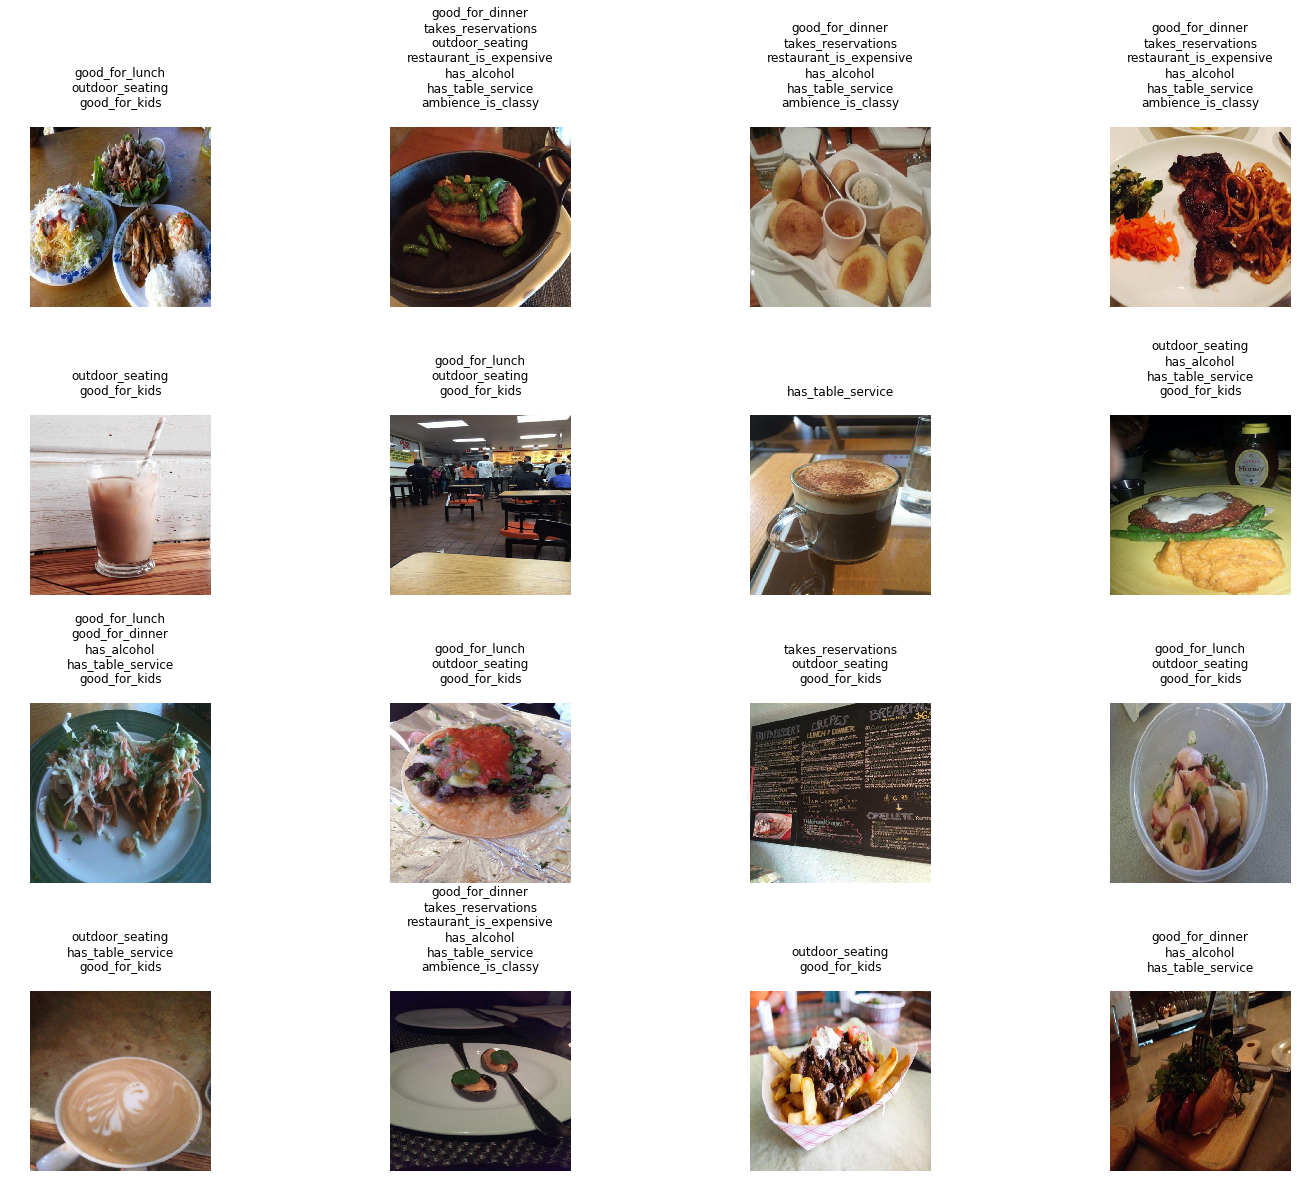

In [4]:
num_samples = 16
xtr, ytr = YelpData.sample_train_images(num_samples, img_preprocess_fn=dflt_img_preprocess_fn, replace=False)
for i in range(num_samples):
    plt.subplot(np.sqrt(num_samples)+1, np.sqrt(num_samples), i+1)
    title_str = "".join([ YelpData.restaurant_attributes[idx] + "\n" for idx,val in enumerate(ytr[i]) if val])
    plt.title(title_str)
    plt.imshow(xtr[i])
    plt.axis('off')
plt.tight_layout(pad=0)

## Sampling images by restaurant class

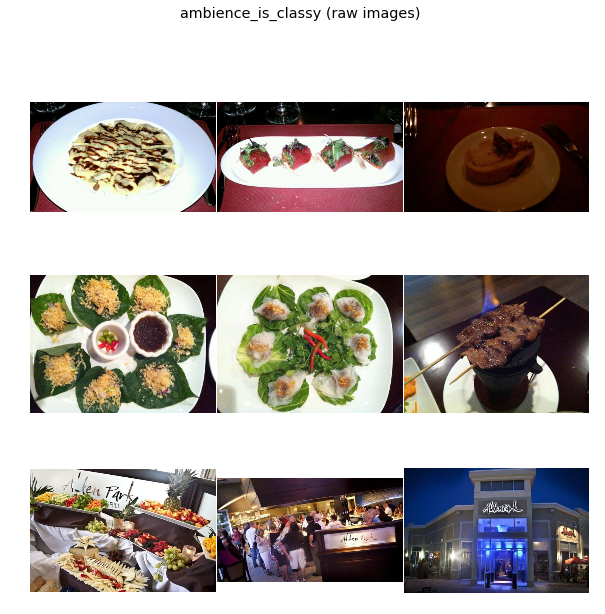

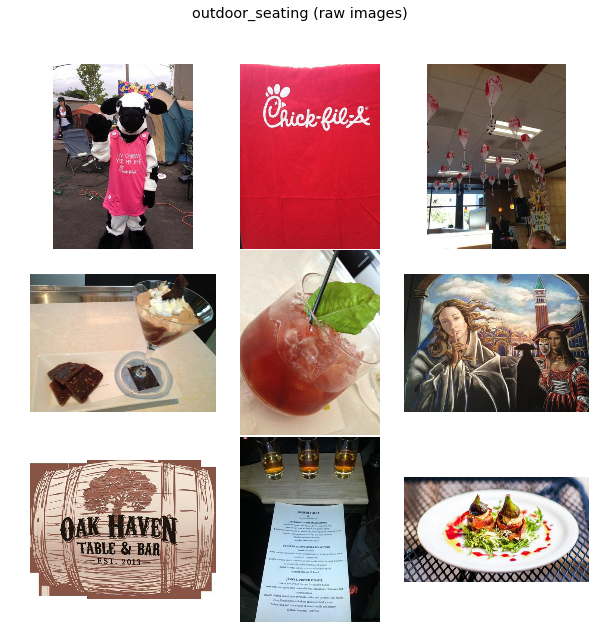

In [5]:
class_names =  ["ambience_is_classy", "outdoor_seating"]
req_max_biz, req_max_imgs_per_biz = 3, 3

for i, class_name in enumerate(class_names):
    fig = plt.figure(i+1, figsize=(10,10))
    st = fig.suptitle(class_name + " (raw images)", fontsize="x-large")    
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    for image_no, img in enumerate(YelpData.iterate_train_images_by_class(
                                       class_name, req_max_biz, req_max_imgs_per_biz, shuffle=True)):
        fig.add_subplot(req_max_biz, req_max_imgs_per_biz, image_no+1)
        plt.axis("off")
        plt.imshow(img)

## Sampling images by business id

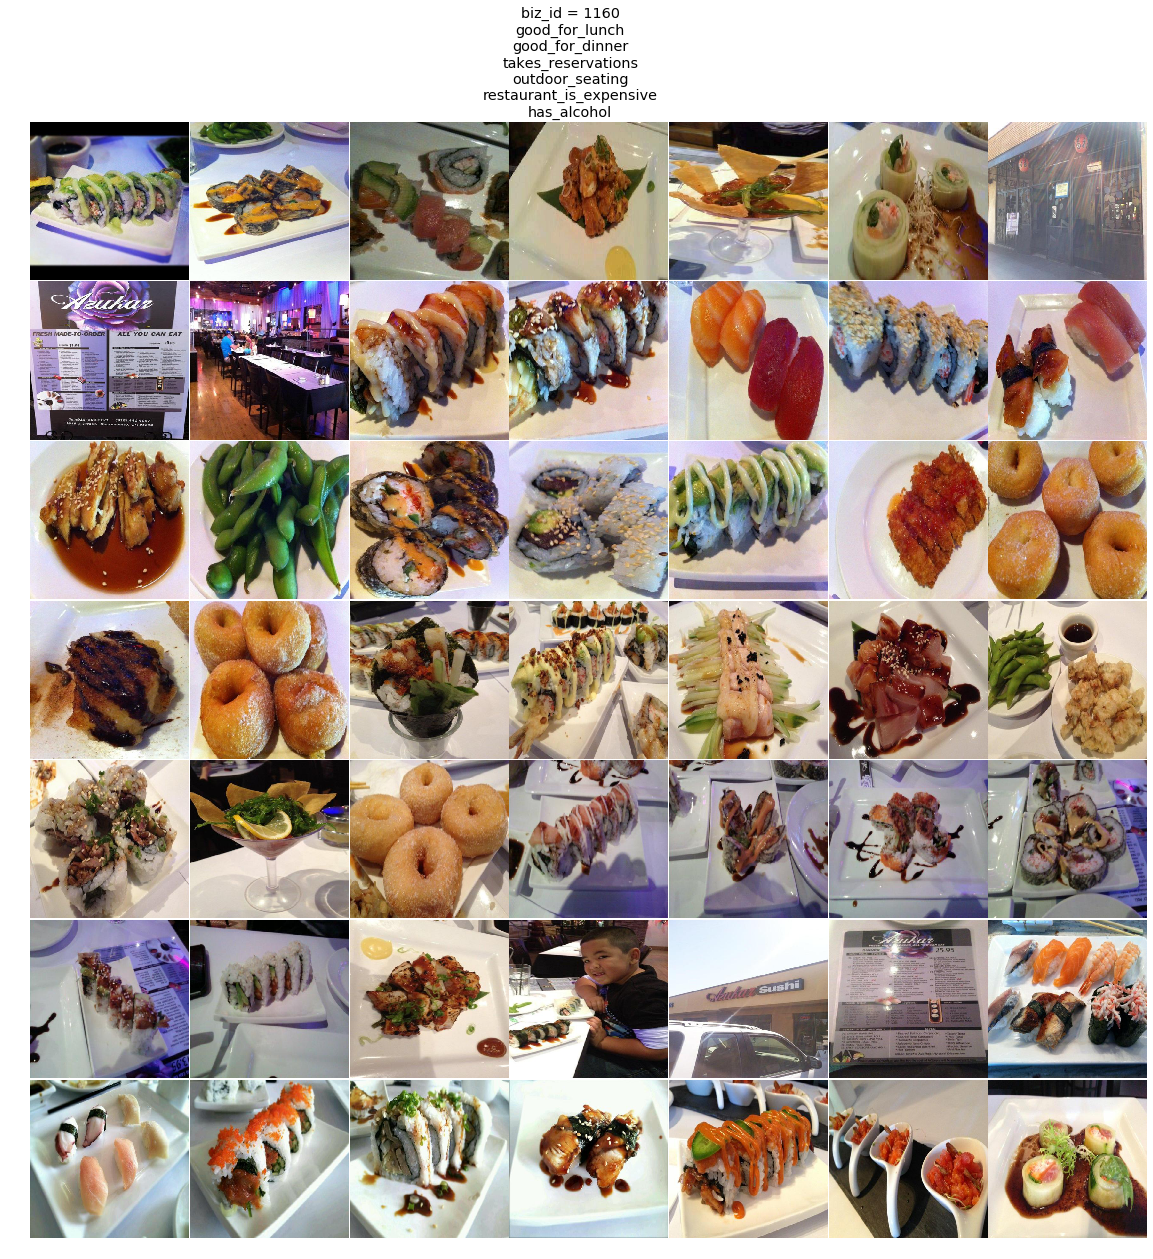

In [6]:
biz_id = YelpData.train_photo_biz_tbl.business_id[np.random.randint(0, YelpData.num_train_biz)]
X_train = YelpData.get_train_images_by_biz_id(biz_id, req_max_imgs=49)
y_train = YelpData.get_train_biz_attribs_by_biz_id(biz_id)
num_imgs = len(X_train)

fig = plt.figure(1, figsize=(20,20))
fig.subplots_adjust(wspace=0.01, hspace=0.01)
title_str = "biz_id = " + str(biz_id) + "\n" \
            + "".join([ YelpData.restaurant_attributes[idx] + "\n" for idx,val in enumerate(y_train) if val])
plt.suptitle(title_str, fontsize="x-large")
for i in range(num_imgs):
    plt.subplot(np.ceil(np.sqrt(num_imgs)), np.ceil(np.sqrt(num_imgs)), i+1)
    plt.imshow(X_train[i])
    plt.axis("off")


## Training image batches

Training batch 1/14660
Finished training...


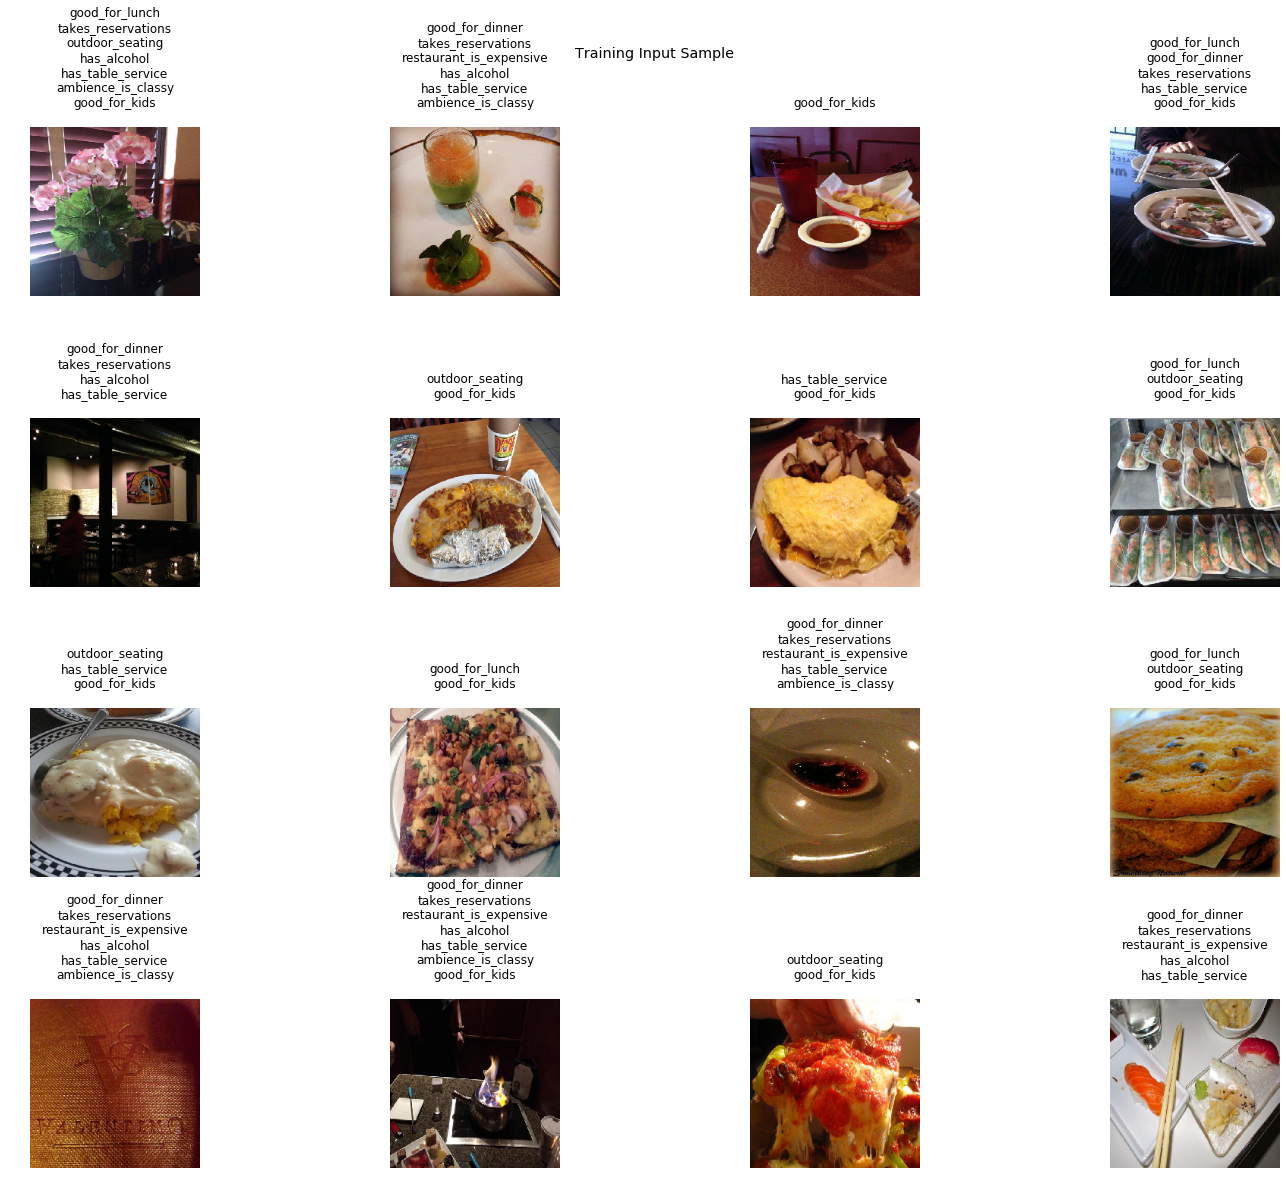

In [7]:
max_epoch = 1
num_epoch = 0
batch_size = 16
batch_count = 0
num_batches = int(np.ceil(YelpData.num_train_images / float(batch_size)))
while num_epoch < max_epoch:
    try:
        
        print("Training batch {}/{}".format(batch_count+1, num_batches))
        xtr, ytr = YelpData.sample_train_images(batch_size, 
                    img_preprocess_fn=lambda x: prepare_image_for_vggnet(x, resize_dim=(224,224,3), 
                                            sub_vgg_mean=False, depth_first=False, dtype=np.uint8), replace=False)
        """
        TRAIN YOUR MODEL HERE
        """
        fig = plt.figure(i+1, figsize=(20,20))
        st = fig.suptitle("Training Input Sample", fontsize="x-large")
        fig.subplots_adjust(wspace=2, hspace=2)
        # e.g. code
        for i in range(batch_size):
            plt.subplot(np.sqrt(batch_size)+1, np.sqrt(batch_size), i+1)
            plt.axis('off')
            title_str = "".join([ YelpData.restaurant_attributes[idx] + "\n" \
                                             for idx,val in enumerate(ytr[i]) if val])
            plt.title(title_str)
            plt.imshow(xtr[i])
        plt.tight_layout(pad=0)
        break
        batch_count += 1
        
    except StopIteration:
        num_epoch += 1
        print("Train Epoch {}/{}".format(num_epoch, max_epoch))
        # reload training data
        YelpData.load_train_data()
        continue
print("Finished training...")

## VGG16 for tansfer Learning 

In [8]:
# VGG16 (trained on ImageNet)
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

## VGG like multilabel CNN Classifier

In [9]:
def yelp_clf_multilabel(
                fc_dims=(1024, 512, 1), input_shape=(3, 224, 224), 
                num_classes=9, fc_l2_reg=0.1, conv_l2_reg=100.0, fc_initialization="he_normal", weights_path=None):
    
    fc1_dim, fc2_dim, output_dim = fc_dims
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=input_shape)
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg)), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg)), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/10)), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/10)), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/10)), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/10)), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/10)), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/100)), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/100)), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', W_regularizer=l2(conv_l2_reg/100)), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2), W_regularizer=l2(conv_l2_reg/100)), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2), W_regularizer=l2(conv_l2_reg/100)), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2), W_regularizer=l2(conv_l2_reg/100)), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="conv13")

    for i in range(num_classes):
        
        layer_name = "h" + str(i) + "fc1"
        m.add_node(Dense(fc1_dim, init=fc_initialization, W_regularizer=l2(fc_l2_reg)), name=layer_name, input="fork")
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc1relu"
        m.add_node(LeakyReLU(), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc1dropout"
        m.add_node(Dropout(0.5), name=layer_name, input=prev_layer)
        
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2"
        m.add_node(Dense(fc1_dim, init=fc_initialization, W_regularizer=l2(fc_l2_reg)), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2relu"
        m.add_node(LeakyReLU(), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2dropout"
        m.add_node(Dropout(0.5), name=layer_name, input=prev_layer)
        
        prev_layer = layer_name
        layer_name = "h" + str(i) + "out"
        m.add_node(Dense(output_dim, activation='sigmoid', 
                             init=fc_initialization, W_regularizer=l2(fc_l2_reg)), name=layer_name, input=prev_layer)
        
        m.add_output(name='class_'+str(i), input=layer_name)
        
# Fully convolutional        
#     m.add_node(Convolution2D(512, 7, 7, activation='relu'), name="conv_1d_0", input="maxp13")
#     m.add_node(Convolution2D(1024, 1, 1, activation='relu'), name="conv_1d_1", input="conv_1d_0")
#     m.add_node(Convolution2D(512, 1, 1, activation='relu'), name="conv_1d_2", input="conv_1d_1")
#     m.add_node(Convolution2D(output_dim, 1, 1, activation='relu'), name="conv_1d_3", input="conv_1d_2")
    
#     m.add_node(Flatten(), name="conv_1d_flat", input="conv_1d_3")
#     m.add_node(Activation('softmax'), name="conv_1d_flat_prob", input="conv_1d_flat") 
#     m.add_output(name='class_probs', input='conv_1d_flat_prob') 

    if weights_path and os.path.isfile(weights_path):
        print "loading pre-trained weights from: ", weights_path
        m.load_weights(weights_path)

    return m

def yelp_clf_multilabel_mini(
                fc_dims=(1024, 512, 1), input_shape=(3, 224, 224), 
                num_classes=9, fc_l2_reg=0.1, fc_initialization="he_normal", weights_path=None):
    
    fc1_dim, fc2_dim, output_dim = fc_dims
    
    m = Graph()
    
    m.add_input(name='input', input_shape=input_shape)
    
    m.add_node(Convolution2D(4, 3, 3, border_mode='same'), name="conv1", input="input")
    m.add_node(LeakyReLU(), name="conv1_act", input="conv1")
    m.add_node(Convolution2D(4, 3, 3, border_mode='same'), name="conv2", input="conv1_act")
    m.add_node(LeakyReLU(), name="conv2_act", input="conv2")
    m.add_node(MaxPooling2D((4,4)), name="maxp2", input="conv2_act")
    
    m.add_node(Convolution2D(8, 3, 3, border_mode='same'), name="conv3", input="maxp2")
    m.add_node(LeakyReLU(), name="conv3_act", input="conv3")
    m.add_node(Convolution2D(8, 3, 3, border_mode='same'), name="conv4", input="conv3_act")
    m.add_node(LeakyReLU(), name="conv4_act", input="conv4")
    m.add_node(MaxPooling2D((4,4)), name="maxp4", input="conv4_act")
    
    m.add_node(Convolution2D(16, 3, 3, border_mode='same'), name="conv5", input="maxp4")
    m.add_node(LeakyReLU(), name="conv5_act", input="conv5")
    m.add_node(Convolution2D(16, 3, 3, border_mode='same'), name="conv6", input="conv5_act")
    m.add_node(LeakyReLU(), name="conv6_act", input="conv6")
    m.add_node(Convolution2D(16, 3, 3, border_mode='same'), name="conv7", input="conv6_act")
    m.add_node(LeakyReLU(), name="conv7_act", input="conv7")
    m.add_node(MaxPooling2D((4,4)), name="maxp7", input="conv7_act")
    
    m.add_node(Flatten(), name="fork", input="maxp7")
    
    for i in range(num_classes):
        
        layer_name = "h" + str(i) + "fc1"
        m.add_node(Dense(fc1_dim, init=fc_initialization, W_regularizer=l2(fc_l2_reg)), name=layer_name, input="fork")
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc1relu"
        m.add_node(LeakyReLU(), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc1dropout"
        m.add_node(Dropout(0.5), name=layer_name, input=prev_layer)
        
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2"
        m.add_node(Dense(fc1_dim, init=fc_initialization, W_regularizer=l2(fc_l2_reg)), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2relu"
        m.add_node(LeakyReLU(), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2dropout"
        m.add_node(Dropout(0.5), name=layer_name, input=prev_layer)
        
        prev_layer = layer_name
        layer_name = "h" + str(i) + "out"
        m.add_node(Dense(output_dim, activation='sigmoid', 
                             init=fc_initialization, W_regularizer=l2(fc_l2_reg)), name=layer_name, input=prev_layer)
        
        m.add_output(name='class_'+str(i), input=layer_name)

    if weights_path and os.path.isfile(weights_path):
        print "loading pre-trained weights from: ", weights_path
        m.load_weights(weights_path)

    return m

# Transfer Learning utility functions
def transfer_learn_conv_layers(dst_model_graph, src_model_seq, transfer_learn_end_layer = "conv13"):
    
    conv_idx = 0
    for i in range(len(src_model_seq.layers)):
        
        # vgg16_model.layers[i].name supported in latest keras
        if "Convolution2D" in str(src_model_seq.layers[i]): 
            
            conv_idx += 1
            conv_layer_name = "conv" + str(conv_idx)
            if conv_layer_name in dst_model_graph.namespace:
                
                print('Transferring weights layer {}(src) -> {}(dst) {}'.format(i, conv_idx, conv_layer_name))
                dst_model_graph.nodes[conv_layer_name].W.set_value(src_model_seq.layers[i].get_weights()[0]);
                dst_model_graph.nodes[conv_layer_name].b.set_value(src_model_seq.layers[i].get_weights()[1]);
        
            if conv_layer_name == transfer_learn_end_layer:
                break
            
def freeze_layers_from_bottom(model_graph, freeze_end_at = "conv4"):

    # freeze bottom layers
    for node_name in model_graph.nodes.keys():
        model_graph.nodes[node_name].trainable = False
        if node_name == freeze_end_at:
            break

## Create model

In [12]:
tiled_input = False
weights_checkpoint_path = "./weights.hdf5"
pretrained_weights_path = None # weights_checkpoint_path
#"./clf_ml_2048_2048_1_lr1e-4_l2reg10.0_convreg0_weights_batch25.h5" 
#"./clf2_256_128_1_lr1e-4_l2reg1.0_weights_epoch_1.h5"
freeze_end_layer = "conv13"
transfer_learn_from_vgg = True
transfer_learn_end_layer = "conv13"

fc_dims = (2048, 2048, 1)
C, W, H = (3, 224, 224)
num_classes = YelpData.num_out_classes
fc_l2_reg = 10 #1e-1
conv_l2_reg = 1.0 
fc_initialization="he_normal"

if tiled_input:
    
    # Tile business images into a single image
    W_tile_cnt = H_tile_cnt = 3
    WW, HH = W_tile_cnt*W, H_tile_cnt*H
    input_shape = (C, WW, HH)
else:
    
    # Train on one image at a time
    input_shape = (C, W, H)
    
print("input_shape: {}x{}x{}".format(*input_shape))
print("tiled_input: {}".format(tiled_input))
print("pretrained_weights_path: {}".format(pretrained_weights_path))
print("freeze_end_layer: {}".format(freeze_end_layer))
print("transfer_learn_from_vgg: {}".format(transfer_learn_from_vgg))
print("transfer_learn_end_layer: {}".format(transfer_learn_end_layer))
print("fc_dims: {}".format(fc_dims))
print("fc_initialization: {}".format(fc_initialization))
print("fc_l2_reg: {}".format(fc_l2_reg))
print("conv_l2_reg: {}".format(conv_l2_reg))
print("\n")

try:
  yelp_model
except NameError:
  pass
else:
    print "Freeing up old model"
    del yelp_model

if pretrained_weights_path and os.path.isfile(pretrained_weights_path):
    
    # start from previous state
    print('Load model with pretrained weights')
    yelp_model = yelp_clf_multilabel(
                        fc_dims=fc_dims, 
                        input_shape=input_shape, 
                        fc_l2_reg=fc_l2_reg, 
                        conv_l2_reg=conv_l2_reg,
                        fc_initialization=fc_initialization,
                        num_classes = num_classes,
                        weights_path=pretrained_weights_path)
else:
    
    # transfer learn from VGG16
    print('Create new model')
    yelp_model = yelp_clf_multilabel(
                        fc_dims=fc_dims, 
                        input_shape=input_shape, 
                        fc_l2_reg=fc_l2_reg,
                        conv_l2_reg=conv_l2_reg,
                        fc_initialization=fc_initialization,
                        num_classes = num_classes,
                        weights_path=None)
    
    if transfer_learn_from_vgg:
        print('Load teacher')
        vgg16_model = VGG_16('../vgg16_weights.h5')
        print('Transfer learn')
        transfer_learn_conv_layers(yelp_model, vgg16_model, transfer_learn_end_layer) # orig: conv13
        del vgg16_model

if freeze_end_layer:
    print('Freeze layers end {}'.format(freeze_end_layer))
    freeze_layers_from_bottom(yelp_model, freeze_end_layer)
        
print('Model Ready')

input_shape: 3x224x224
tiled_input: False
pretrained_weights_path: None
freeze_end_layer: conv13
transfer_learn_from_vgg: True
transfer_learn_end_layer: conv13
fc_dims: (2048, 2048, 1)
fc_initialization: he_normal
fc_l2_reg: 10
conv_l2_reg: 1.0


Freeing up old model
Create new model
Load teacher
Transfer learn
Transferring weights layer 1(src) -> 1(dst) conv1
Transferring weights layer 3(src) -> 2(dst) conv2
Transferring weights layer 6(src) -> 3(dst) conv3
Transferring weights layer 8(src) -> 4(dst) conv4
Transferring weights layer 11(src) -> 5(dst) conv5
Transferring weights layer 13(src) -> 6(dst) conv6
Transferring weights layer 15(src) -> 7(dst) conv7
Transferring weights layer 18(src) -> 8(dst) conv8
Transferring weights layer 20(src) -> 9(dst) conv9
Transferring weights layer 22(src) -> 10(dst) conv10
Transferring weights layer 25(src) -> 11(dst) conv11
Transferring weights layer 27(src) -> 12(dst) conv12
Transferring weights layer 29(src) -> 13(dst) conv13
Freeze layers end co

In [ ]:
def biz_img_tiled_minibatch(photo_biz_id_tbl, image_by_biz_id_fn, one_hot_enc_attrib_by_biz_id_fn, 
                                    is_train=True, resume_from=0, batch_size=4, 
                                    tiling_para=(3,3), resize_dim=(224,224,3), 
                                    vgg_para=(False, False, np.uint8), shuffle_biz_imgs=True):
    
    """
    Args:
        tiling_para: (W_tile_cnt, H_tile_cnt)
        resize_dim: (W, H, C)
        vgg_para: (sub_vgg_mean, depth_first, dtype)
    """
    
    W_tile_cnt, H_tile_cnt = tiling_para
    W, H, C = resize_dim
    WT, HT = W_tile_cnt*W, H_tile_cnt*H
    num_images_tiled = W_tile_cnt*H_tile_cnt 
    sub_vgg_mean, depth_first, dtype = vgg_para
    
    biz_id_list = photo_biz_id_tbl.business_id.unique()
    biz_id_iter_loc = resume_from
    num_biz_id = len(biz_id_list)-biz_id_iter_loc

    num_batches = num_biz_id / batch_size # TODO: remaining samples
    
    n_pos, c_pos, w_pos, h_pos = (0, 1, 2, 3) if depth_first else (0, 3, 1, 2)
    
    for batch_no in xrange(num_batches):
        
        Xtr_tiled = np.zeros((batch_size, C, WT, HT), dtype=dtype)
        
        if is_train:
            ytr_tiled = np.zeros((batch_size, YelpData.num_out_classes), dtype=dtype)
    
        for biz_no, biz_id in enumerate(biz_id_list[biz_id_iter_loc: biz_id_iter_loc+batch_size]):
            xtr = image_by_biz_id_fn(biz_id, 
                                    lambda x: prepare_image_for_vggnet(
                                        x, (W,H,C), sub_vgg_mean, depth_first, dtype),  
                                    req_max_imgs=num_images_tiled, 
                                    shuffle=shuffle_biz_imgs)
            
            """ 
            A mindblowingly complicated transofrmation:
            It takes fixed number of images of a particular business, and tiles them to create a single larger image.
            If any business has less images, then the same images are repeated to create a consistent sized image for 
            training.
            """
            Xtr_tiled[biz_no, :, :, :] = \
                    np.tile(xtr, (np.ceil(float(num_images_tiled)/len(xtr)),1,1,1))[:num_images_tiled].transpose(
                        c_pos,n_pos,w_pos,h_pos).reshape(
                                C,W_tile_cnt,H_tile_cnt,W,H).transpose(0,1,3,2,4).reshape(C, WT, HT)
                
            if is_train:
                ytr_tiled[biz_no,:] = one_hot_enc_attrib_by_biz_id_fn(biz_id)
        
        if is_train:
            yield Xtr_tiled, ytr_tiled
        else:
            yield Xtr_tiled
        
    raise StopIteration()
    
def train_biz_image_tiled_minibatch(resume_from=0, batch_size=4, 
                                    tiling_para=(3,3), resize_dim=(224,224,3), 
                                    vgg_para=(False, False, np.uint8), shuffle_biz_imgs=True):
    
    return biz_img_tiled_minibatch(YelpData.train_photo_biz_tbl, 
                                    YelpData.get_train_images_by_biz_id, 
                                    YelpData.get_train_biz_attribs_one_hot_by_biz_id,
                                    is_train=True, resume_from=resume_from, batch_size=batch_size, 
                                    tiling_para=tiling_para, resize_dim=resize_dim, 
                                    vgg_para=vgg_para, shuffle_biz_imgs=shuffle_biz_imgs)

def test_biz_image_tiled_minibatch(resume_from=0, batch_size=4, 
                                    tiling_para=(3,3), resize_dim=(224,224,3), 
                                    vgg_para=(False, False, np.uint8), shuffle_biz_imgs=True):
    
    return biz_img_tiled_minibatch(YelpData.test_photo_biz_tbl, 
                                    YelpData.get_test_images_by_biz_id, 
                                    None,
                                    is_train=False, resume_from=resume_from, batch_size=batch_size, 
                                    tiling_para=tiling_para, resize_dim=resize_dim, 
                                    vgg_para=vgg_para, shuffle_biz_imgs=shuffle_biz_imgs)

## Display model

In [ ]:
plot(yelp_model, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png')
# or 
# SVG(to_graph(yelp_model, show_shape=True).create(prog='dot', format='svg'))

## Optimization

In [ ]:
# Callbacks
tr_loss, tr_acc, val_loss, val_acc = [], [], [], []

class LossHistory(callbacks.Callback):
    
    def on_batch_end(self, batch, logs={}):
        tr_loss.append(logs.get('loss'))
#         tr_acc.append(logs.get('acc'))
#         val_loss.append(logs.get('val_loss'))
#         val_acc.append(logs.get('val_acc'))
       
history_cb = LossHistory()
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
checkpointer_cb = callbacks.ModelCheckpoint(filepath=weights_checkpoint_path, 
                                                            verbose=1, save_best_only=True)
remote = callbacks.RemoteMonitor(root='http://localhost:9000') #https://github.com/fchollet/hualos

In [ ]:
# yelp_model.load_weights(pretrained_weights_path)

In [ ]:
# Compile model
loss_dict = {}
for i in range(len(YelpData.restaurant_attributes)):
    loss_dict['class_'+str(i)] = 'binary_crossentropy'

# loss_dict = {'class_probs':'categorical_crossentropy'}

# sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
yelp_model.compile(optimizer=adam, loss=loss_dict)

## Image batchwise training

In [ ]:
def print_accuracy(x_in,y_out,msg=""): 
    predictions = yelp_model.predict({'input': x_in}, batch_size=32)
    pred_mat = np.array([predictions["class_"+str(i)] for i in range(YelpData.num_out_classes)]).squeeze(
                                        ).transpose(1,0)
    pred_mat[pred_mat < 0.5] = 0
    pred_mat[pred_mat >= 0.5] = 1
    diff_out = np.sum(y_out == pred_mat, axis=1)
    print("{} Acc = {}, Strict Acc = {}".format(msg, np.mean(diff_out/9.0), np.mean(diff_out/9)))

### Overfit a small dataset

In [ ]:
training_batch_size = 10
BatchGenerator = YelpData.iterate_train_images_batch(training_batch_size, 
                                    img_preprocess_fn=lambda x: prepare_image_for_vggnet(x, resize_dim=(224,224,3), 
                                            sub_vgg_mean=False, depth_first=True, dtype=np.float32), 
                                     shuffle=False, replace=False)

try:
    xval, yval = next(BatchGenerator)
except StopIteration:
    print "finished epoch"
    
max_epoch = 1
num_epoch = 0
batch_count = 0
num_batches = int(np.ceil(YelpData.num_train_images / float(training_batch_size)))
tr_loss, tr_acc, val_loss, val_acc = [], [], [], []

try:
    xtr, ytr = next(BatchGenerator)
    keras_training_input = { 'input': xtr } #, 'class_probs': ytr
    for i in range(YelpData.num_out_classes):
        keras_training_input['class_'+str(i)] = ytr[:,i]
    yelp_model.fit( keras_training_input, batch_size=16, 
                    verbose=1, nb_epoch=10, validation_split=None, 
                    shuffle=True,
                    callbacks=[history_cb, remote] )
except StopIteration:
    num_epoch += 1
    print("finished epoch, epoch: {}/{}".format(num_epoch, max_epoch))
            
print("*** Finished training ***")

In [ ]:
print_accuracy(xtr, ytr, "Training")
print_accuracy(xval, yval, "Validation")

In [ ]:
training_batch_size = 1000
BatchGenerator = YelpData.iterate_train_images_batch(training_batch_size, 
                                    img_preprocess_fn=lambda x: prepare_image_for_vggnet(x, resize_dim=(224,224,3), 
                                            sub_vgg_mean=False, depth_first=True, dtype=np.float32), 
                                     shuffle=False, replace=False)

In [ ]:
try:
    xval, yval = next(BatchGenerator)
except StopIteration:
    print "finished epoch"

In [ ]:
max_epoch = 10
num_epoch = 0
batch_count = 0
tr_loss, tr_acc, val_loss, val_acc = [], [], [], []
num_batches = int(np.ceil(YelpData.num_train_images / float(training_batch_size)))
while num_epoch < max_epoch:
    
    YelpData.load_train_data()
    
    while True:
        try:
            xtr, ytr = next(BatchGenerator)
            keras_training_input = { 'input': xtr } #, 'class_probs': ytr
            for i in range(YelpData.num_out_classes):
                keras_training_input['class_'+str(i)] = ytr[:,i]
            yelp_model.fit( keras_training_input, batch_size=32, 
                            verbose=1, nb_epoch=1, validation_split=0.2, 
                            shuffle=True,
                            callbacks=[history_cb, checkpointer_cb, remote] )
            print("Image batch completed: {}/{}".format(batch_count+1, num_batches))
            print_accuracy(xtr[:100],ytr[:100],"Training")
            print_accuracy(xval[:100],yval[:100],"Validation")
        except StopIteration:
            num_epoch += 1
            print("finished epoch, epoch: {}/{}".format(num_epoch, max_epoch))
            break
            
        batch_count += 1
print("*** Finished training ***")

## Image tiled training

In [ ]:
# separate validation set
training_batch_size = 20
num_valid = training_batch_size
BatchGenerator = train_biz_image_tiled_minibatch(0, num_valid, tiling_para=(4,4), 
                                            resize_dim=(224,224,3), vgg_para=(True,True,np.uint32))

try:
    xval, yval = next(BatchGenerator)
except StopIteration:
    print "finished epoch"

In [ ]:
num_epoch = 0
max_epoch = 1
batch_count = 0

while num_epoch < max_epoch:
    
    BatchGenerator = biz_img_tiled_minibatch(num_valid, training_batch_size, tiling_para=(4,4), 
                                            resize_dim=(224,224,3), vgg_para=(True,True,np.uint32))
    
    while True:
        try:
            xtr, ytr = next(BatchGenerator)
            keras_training_input = { 'input': xtr } #, 'class_probs': ytr
            for i in range(YelpData.num_out_classes):
                keras_training_input['class_'+str(i)] = ytr[:,i]

            yelp_model.fit( keras_training_input, batch_size=2, 
                            verbose=1, nb_epoch=1, validation_split=0.2, 
                            shuffle=True, 
                            callbacks=[history_cb, remote] )

            batch_count += 1
            print('Number of business trained : {} range {}-{}/{}'.format(
                            (batch_count)*training_batch_size, 
                            num_valid+(batch_count)*training_batch_size, 
                            num_valid+(batch_count+1)*training_batch_size, YelpData.num_train_biz))

        except StopIteration:
            num_epoch += 1
            print("finished epoch, epoch = {}/{}".format(num_epoch, max_epoch))
            break
        
        
print("*** Finished training ***")

In [ ]:
# Validation accuracy
print_accuracy(xval, yval, "Validation")

In [ ]:
# yelp_model.save_weights("./clf2_256_128_1_lr1e-4_l2reg1.0_weights_epoch_1.h5")
yelp_model.save_weights("./clf_ml_512_256_1_lr1e-4_l2reg1.0_convreg1.0_weights_vggvanilla.h5")

## Test data

In [ ]:
YelpData.load_test_data()

In [ ]:
# Simple model

if os.path.isfile("./submission.csv"):
    test_results_frame = pd.read_csv("./submission.csv")
else:
    test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
    
biz_covered = len(test_results_frame)

print("Resuming from biz no: {}".format(biz_covered))

BatchGenerator = YelpData.iterate_test_biz_images(img_preprocess_fn=lambda x: 
                                                    prepare_image_for_vggnet(x, resize_dim=(224,224,3), 
                                                    sub_vgg_mean=False, depth_first=True, dtype=np.float32),
                                                 req_max_imgs=None, resume_from=biz_covered)

count = biz_covered
while True:
    try:
        
        print "...",
        biz_id, xtest = next(BatchGenerator)
        predictions = yelp_model.predict({'input': xtest}, batch_size=32) # {class_name: num_samples x 1}
        
        predictions_mat = np.array([predictions["class_"+str(i)] for i in range(YelpData.num_out_classes)]).squeeze()
            
        if len(predictions_mat.shape) == 2:
            predictions_mat = predictions_mat.transpose(1,0)
        else:
            predictions_mat = np.expand_dims(predictions_mat, axis=0)
            
        predictions_mat[predictions_mat < 0.5] = 0
        predictions_mat[predictions_mat >= 0.5] = 1

        biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) \
                                                         if np.mean(predictions_mat[:, i]) > 0.1 ])
        test_results_frame.loc[count] = biz_id, biz_pred_str
        count += 1
        if count % 100 == 0:
            print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))
            test_results_frame.to_csv("./submission.csv", index=None)
            
    except StopIteration:
        print "Finished inference on test set"
        test_results_frame.to_csv("./submission.csv", index=None)
        break

In [ ]:
# Tiled image input model

test_batch_size = 20
test_results_frame = pd.DataFrame(columns=("business_id", "labels"))

BatchGenerator = test_biz_image_tiled_minibatch(0, test_batch_size, tiling_para=(4,4), 
                                            resize_dim=(224,224,3), vgg_para=(True,True,np.uint32))

count = 0
while True:
    try:
        xtest = next(BatchGenerator)
        predictions = yelp_model.predict({'input': xtest}, batch_size=1) # {class_name: num_samples x 1}
        predictions_mat = np.expand_dims(np.array(predictions.values()).squeeze(), axis=0) # 1 x num_classes
        predictions_mat[predictions_mat < 0.5] = 0
        predictions_mat[predictions_mat >= 0.5] = 1

        biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) if np.sum(predictions_mat[:, i])])
        test_results_frame.loc[count] = biz_id, biz_pred_str
        count += 1
        if count % 200 == 0:
            print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))
            test_results_frame.to_csv("./submission.csv", index=None)
            
    except StopIteration:
        print "Finished inference on test set"
        test_results_frame.to_csv("./submission.csv", index=None)
        break

## Scratchpad

### Statistical mean guess

In [ ]:
tbl2 = YelpData.train_biz_attrib_tbl.copy()
for attrib_key, attrib in enumerate(YelpData.restaurant_attributes):
    tbl2[attrib] = tbl2['labels'].str.contains(str(attrib_key))
    
tbs = YelpData.num_test_biz
for i, cls in enumerate(YelpData.restaurant_attributes):
    cls_mu = np.mean(tbl2[cls])
    print("{}: mu = {}".format(cls, cls_mu))
    if i == 0:
        preds = np.random.binomial(1, cls_mu, (tbs,1))
    else:
        preds = np.hstack([preds, np.random.binomial(1, cls_mu, (tbs,1))])

# test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
# for biz_idx, biz_id in enumerate(YelpData.test_photo_biz_tbl.business_id.unique()):
    
#     biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) if preds[biz_idx,i]])
#     test_results_frame.loc[count] = biz_id, biz_pred_str
#     if biz_idx % 1000 == 0:
#         print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))

### Random Guess

In [ ]:
test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
count = 0
for (biz_id, X_test) in YelpData.iterate_test_biz_images(image_proprocess_vggnet, 
                                                            req_max_imgs=num_biz_image_tiles, shuffle=True):
    predictions_mat = np.random.binomial(1, 0.5, (1, YelpData.num_out_classes))
    biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) if np.sum(predictions_mat[:, i])])
    test_results_frame.loc[count] = biz_id, biz_pred_str     
    count += 1
    if count % 100 == 0:
        test_results_frame.to_csv("./submission.csv", index=None) 
        print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))

## GPU Test

In [ ]:
# GPU test: http://deeplearning.net/software/theano/tutorial/using_gpu.html

from theano import function, config, shared, tensor, sandbox
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')


In [ ]:
# Check GPU Memory 
import theano.sandbox.cuda.basic_ops as sbcuda
import theano.tensor as T
T.config.floatX = 'float32'
GPUFreeMemoryInBytes = sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]
freeGPUMemInGBs = GPUFreeMemoryInBytes/1024./1024/1024
print "Your GPU has %s GBs of free memory" % str(freeGPUMemInGBs)

In [ ]:
# Display vgg16 model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
vgg16_model.compile(optimizer=sgd, loss='categorical_crossentropy')
SVG(to_graph(vgg16_model, show_shape=True).create(prog='dot', format='svg'))

## Min business images analysis

In [ ]:
train_biz_ids = YelpData.train_biz_attrib_tbl.business_id.unique()
n_img_per_biz = np.array([ len(YelpData.get_train_image_ids_by_biz_id(biz_id)) for biz_id in train_biz_ids])
print('images per biz min = {}, max = {}, mean = {}, std = {}'.format(
        n_img_per_biz.min(), n_img_per_biz.max(), n_img_per_biz.mean(), n_img_per_biz.std()))
plt.hist(n_img_per_biz, log = False, bins = YelpData.num_train_biz)
plt.title("Histogram: number of images per business")
plt.xlabel("No. of images")
plt.xlabel("No. of businesses")

In [ ]:
print("mean {}, std {}".format(np.mean(n_img_per_biz), np.std(n_img_per_biz))) 

In [ ]:
def threshold_effect(t):
    
    num_biz = np.sum(n_img_per_biz < t)
    percent_biz = 100*np.sum(n_img_per_biz < t)/float(len(n_img_per_biz))
    
    num_imgs = np.sum(n_img_per_biz < t)
    percent_imgs = 100*np.sum(n_img_per_biz[n_img_per_biz < t])/float(np.sum(n_img_per_biz))
    # print('t = {}, compromises biz {}%, training images {}%'.format(t, percent_biz, percent_imgs))
    return percent_biz, percent_imgs

In [ ]:
threshold_effect(15)

*Need a model which takes variable number of images from a business as input and maps it to business attributes. This is tricky. One way to do so is to train the model with least amount of images available per business. But, the minimum is two which isn't sufficient for learning all the attributes. So we'd have to sacrifice some businesses. As it can be seen, there are 107 businesses which has < 15 images, contributing to total of 1139 images of the dataset, which seems like a pretty good threshold because it's only 0.48% of the total training images. Let's check the effect of threshold values in range 0-100*

In [ ]:
t_result_biz = []
t_result_imgs = []
t_range = range(101)
for t in t_range:
    b, i = threshold_effect(t)
    t_result_biz.append(b)
    t_result_imgs.append(i)
    
plt.xlabel("num image threshold per business")
plt.plot(t_range, t_result_biz, color="r", label="% business affected")
plt.plot(t_range, t_result_imgs, color="b", label="% images affected")
plt.legend()

Looking at the graph, presumably threshold 20 should be a good number of minimum images to filter businesses for training without impacting too much of a performance. 

In [ ]:
print threshold_effect(20)